In [1]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [69]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.neighbors import BallTree, NearestNeighbors
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [3]:
import json
entities = []
with open('../data/embedding/entites.txt', 'r', encoding='utf-8') as f:
    line = f.readline()
    while line:
        valid_json_line = line.replace(r"'", '"')
        entities.append(json.loads(valid_json_line))
        line = f.readline()

In [ ]:
entities = np.array(entities)

In [24]:
vect = TfidfVectorizer()
entity_words = [' '.join(entity) for entity in entities]
tfidf = vect.fit_transform(entity_words)

In [12]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
# article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [13]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [14]:
article_df.shape

(213605, 9)

In [15]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(177172, 9)

In [9]:
def load_label(file='lower_bound'):
    label1 = pd.read_csv(f'../data/raw/labels/cave_rescue/{file}.txt', header=None)
    label1.columns = ['canonicalUrl']
    label1['label'] = 'cave_rescue'

    label2 = pd.read_csv(f'../data/raw/labels/duckboat/{file}.txt', header=None)
    label2.columns = ['canonicalUrl']
    label2['label'] = 'duckboat'

    label3 = pd.read_csv(f'../data/raw/labels/helsinki_summit/{file}.txt', header=None)
    label3.columns = ['canonicalUrl']
    label3['label'] = 'helsinki'

    label_df = pd.concat([label1, label2, label3])
    return label_df
label_df = load_label('lower_bound')

In [16]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [17]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [18]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((140, 10), (177032, 10))

Sample and include all the labeled article

In [27]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [28]:
sample_emb = tfidf[sample_df.index]

In [50]:
pct = np.percentile(euclidean_distances(sample_emb), 3); pct

0.9999999999999998

In [51]:
nn = NearestNeighbors(radius=pct)
nn.fit(sample_emb)
admat = nn.radius_neighbors_graph(); admat

<10140x10140 sparse matrix of type '<class 'numpy.float64'>'
	with 2821914 stored elements in Compressed Sparse Row format>

In [52]:
G = nx.from_scipy_sparse_matrix(admat)

In [ ]:
# # if out of memory
# del entities
# del temp
# import gc
# gc.collect()

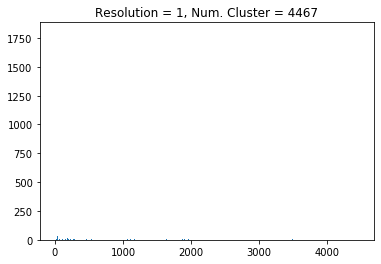

In [53]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [54]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(14, 1796, 1.0)

In [108]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    pc[-1] = []
    for key, values in clusters.items():
        if len(values) > threshold:
            pc[key] = values
            
        else:
            pc[-1] += values
    return pc

In [109]:
pc = prune_cluster(cluster, 5)

In [110]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

108

In [111]:
len(article_cluster[0].title.tolist())

5221

In [112]:
pc.keys()

dict_keys([-1, 0, 2, 3, 11, 14, 16, 19, 20, 28, 29, 32, 33, 39, 40, 45, 46, 48, 51, 55, 57, 61, 62, 64, 65, 66, 67, 84, 88, 90, 91, 92, 97, 103, 104, 105, 123, 136, 137, 160, 169, 170, 171, 174, 177, 186, 189, 201, 207, 216, 227, 230, 232, 234, 238, 249, 253, 258, 290, 308, 315, 358, 365, 400, 401, 420, 440, 476, 486, 506, 512, 519, 538, 560, 590, 599, 608, 643, 663, 668, 732, 771, 826, 851, 884, 887, 896, 938, 984, 1111, 1166, 1210, 1262, 1374, 1387, 1394, 1399, 1440, 1556, 1569, 1642, 1675, 1816, 1957, 1962, 2335, 2607, 3223])

## Top clusters

In [113]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1796,  595,  272,  260,  240,  187,  125,   96,   86,   78,   58,
         48,   36,   34,   30,   29,   27,   26,   26,   24,   20,   20,
         18,   17,   17,   17,   17,   16,   16,   16,   15,   15,   15,
         15,   15,   14,   13,   12,   12,   12,   12,   12,   12,   12,
         12,   11,   11,   11,   10,   10,   10,   10,   10,   10,   10,
         10,   10,    9,    9,    9,    9,    9,    8,    8,    8,    8,
          8,    8,    8,    8,    8,    7,    7,    7,    7,    7,    7,
          7,    7,    7,    7,    7,    7,    7,    7,    7,    7,    7,
          7,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
          6,    6,    6,    6,    6,    6,    6,    6])

In [114]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
31512,16,news.google.com/stories/caaqaagkimjdqkltuxpvsm...,7/19/2018 5:36:57 PM -04:00,meets Vladimir Putin - Overview,Donald Trump meets Vladimir Putin ### Top cove...,1,en,31,13277,helsinki
28515,474,democratandchronicle.com/picture-gallery/sport...,7/19/2018 7:25:23 PM -04:00,Jim Kelly gives emotional speech at ESPYs,FacebookEmail Twitter Google+ LinkedIn Pintere...,1,en,41,3100,NaN
28514,474,democratandchronicle.com/story/sports/olympics...,7/19/2018 7:33:38 PM -04:00,"Denis Ten, Olympic figure skater and medalist,...",To find out more about Facebook commenting ple...,1,en,66,2537,NaN
30278,641,gameinformer.com/gamer-culture/2018/07/19/star...,7/20/2018 1:32:44 AM -04:00,Star Wars: Clone Wars CG Series Returning,Star Wars: Clone Wars CG Series Returning ### ...,1,en,41,1041,NaN
28131,183,radaronline.com/exclusives/2018/07/alaskan-bus...,7/20/2018 7:32:23 AM -04:00,‘Alaskan Bush’ Star Noah Brown Celebrates Birt...,‘Alaskan Bush’ Star Noah Brown Celebrates Birt...,1,en,65,1564,NaN


In [65]:
print('\n'.join(top_cluster.title.tolist()[:10]))

News Media Find Trump Guilty of Treason
Multiple People Are Injured After A Tourist Boat Capsized In Missouri
Eight Die After Boat Capsizes in Storm Near Branson, Mo.  - WSJ
Sheriff: 8 dead after Missouri tourist boat accident
Duck boat capsizes on Missouri lake; multiple casualties reported | Fox News
timeline: The dangerous race to bring trapped soccer team home
Trump invites Putin to US as Democrats call for Helsinki details
Sheriff: 8 dead, several injured after Missouri tourist boat capsizes in storm
Just Acknowledged Russian Meddling in the 2016 Election
approved announcing Mueller's latest Russia indictment ahead of his meeting with Putin: source


In [121]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

C:\Users\harinsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [122]:
articles = pd.concat(article_cluster)
articles.shape

(10140, 11)

In [123]:
k = KMeans(n_clusters=len(cluster_sizes), n_jobs=-1)
y_kmean = k.fit_predict(sample_emb); y_kmean

KeyboardInterrupt: 

In [124]:
articles['y_kmean'] = y_kmean

In [125]:
labeled_articles = articles.dropna(subset=['label'])

In [139]:
from sklearn.metrics import precision_recall_fscore_support

def get_largest_cluster(y_pred):
    print(len(y_pred))
    cluster_size = {}
    cluster_labels = set(y_pred)
    max_cluster_label = -1
    max_cluster_size = -1
    for cluster_label in cluster_labels:
        count = np.sum(y_pred == cluster_label)
        if count > max_cluster_size:
            max_cluster_label = cluster_label
            max_cluster_size = count
    return max_cluster_label, max_cluster_size

def max_cluster_acc(y_true, y_pred, name=None):
    labels = set(y_true)
    result = []
    for label in labels:
        if not isinstance(label, str): continue # remove NaN
        label_y_true = (y_true == label).astype(int)
        
        # get cluster with the largest population of label
        max_cluster_label, max_cluster_size = get_largest_cluster(y_pred.iloc[label_y_true])
        label_y_pred = (y_pred == max_cluster_label).astype(int)
        precision, recall, f_score, support = precision_recall_fscore_support(
            label_y_true, label_y_pred, average=None
        )
        
        scores = {
            'label': label,
            'precision': precision[1],
            'recall': recall[1],
            'f_score': f_score[1]
        }
        if name: scores['name'] = name
        result.append(scores)
        
    return result
        

results = max_cluster_acc(labeled_articles.label, labeled_articles.assignment, 'cd') +  max_cluster_acc(labeled_articles.label, labeled_articles.y_kmean, 'kmean')

140
140
140
140
140
140


In [140]:
result_df = pd.DataFrame(results)
result_df

,label,precision,recall,f_score,name
0,helsinki,0.575758,0.431818,0.493506,cd
1,duckboat,0.181818,0.571429,0.275862,cd
2,cave_rescue,0.242424,0.516129,0.329897,cd
3,helsinki,0.532258,0.375000,0.440000,kmean
4,duckboat,0.263158,0.238095,0.250000,kmean
5,cave_rescue,0.052632,0.032258,0.040000,kmean


In [158]:
metrics = ['precision', 'recall', 'f_score']
for metric in metrics:
    print(metric)
    print('-'*50)
    precision_df = result_df.pivot('label', 'name', metric)
    mean_series = precision_df.mean()
    mean_series.name  = 'mean'
    precision_df = precision_df.append(mean_series)
    print(precision_df)
    print('\n')

precision
--------------------------------------------------
name               cd     kmean
label                          
cave_rescue  0.242424  0.052632
duckboat     0.181818  0.263158
helsinki     0.575758  0.532258
mean         0.333333  0.282683


recall
--------------------------------------------------
name               cd     kmean
label                          
cave_rescue  0.516129  0.032258
duckboat     0.571429  0.238095
helsinki     0.431818  0.375000
mean         0.506459  0.215118


f_score
--------------------------------------------------
name               cd     kmean
label                          
cave_rescue  0.329897  0.040000
duckboat     0.275862  0.250000
helsinki     0.493506  0.440000
mean         0.366422  0.243333




In [159]:
result_df.groupby('name').mean()

,precision,recall,f_score
name,,,
cd,0.333333,0.506459,0.366422
kmean,0.282683,0.215118,0.243333
